# Homework 2 Excercise 3 - Image Denoiser

Brennan McFarland  
bfm21

In order to denoise an image, we must first create an appropriate representation of it in memory.  We can represent the noisy image as an array of binary pixel values y<sub>i</sub> in {-1, +1} where i is the pixel number, -1 is black and 1 is white.  We can thus derive the most probable denoised image based on the noisy image.

## Load Image

First we need to load the image as greyscale.  Python treats the image as an array of values on the scale of [0, 1], where 0 is black and 1 is white.

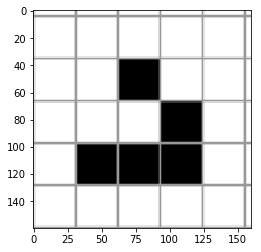

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imtool
from scipy.signal import convolve2d as conv2d
from skimage import io

nratio = .1
imorg = io.imread('glider.png', as_grey=True)
plt.imshow(imorg, cmap='gray')

black_value, white_value = -1.0, 1.0

## Add Noise

To generate a noisy version of the image to apply our denoising algorithm to, we use essentially the same noise function as in the lecture example, but adapt it to return greyscale float values uniformly sampled from [0, 1]:

In [5]:
def addnoise(imorg, nratio=0.1):
    imnsy = imorg.copy()
    index = np.random.rand(*imnsy.shape)
    # flip pixels to generate noisy image
    for r in range(len(imnsy)):
        for c in range(len(imnsy[r])):
            if index[r][c] < nratio:
                imnsy[r][c] = np.random.uniform(0.0, 1.0)
    return imnsy

In [6]:
def showimgs(*args, ncol=2):
    if not args:
        return
    imgs = args[0:len(args)-1:2]
    titles = args[1:len(args):2]
    # initialize figure with specific size
    plt.figure(figsize=(16, 10))
    # compose subplot index
    nrow = np.ceil(len(imgs) / ncol)
    subindex = nrow * 100 + ncol * 10
    # draw each image in subplot
    for i, img, title in zip(range(len(imgs)), imgs, titles):
        ax = plt.subplot(subindex + i + 1)
        ax.set_title(title)
        plt.imshow(img, cmap='gray')

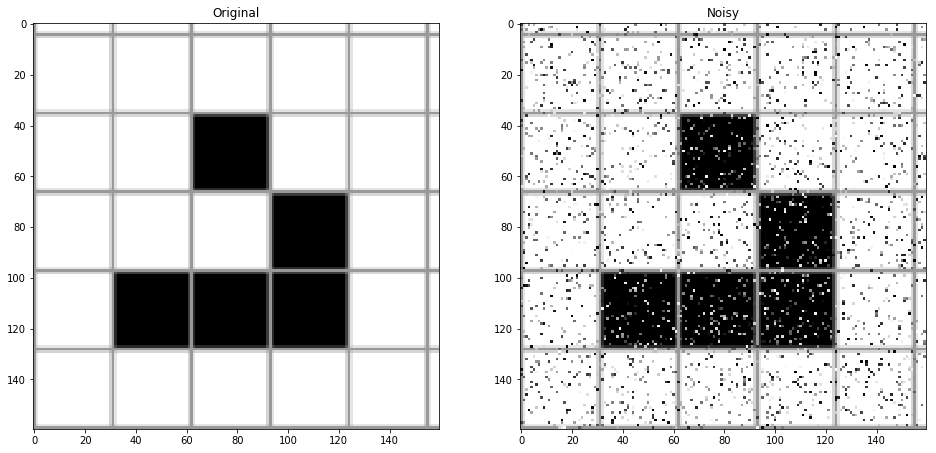

In [7]:
imnsy = addnoise(imorg, nratio = 0.1)
showimgs(imorg, "Original", imnsy, "Noisy")

## Probability/Energy Function

We can characterize the relationship between the noisy and denoised image as the energy function
$$E(X,Y) = \alpha\sum\limits_{i} x_i - \beta \sum\limits_{i,j} x_i x_j - \eta \sum\limits_{i} x_i y_i $$
where $\alpha$ is the noise bias, eg, the proportion of white pixels in the image on a scale of [-1, 1],  
$\beta$ is the coefficient for the relationship between a pixel and its neighbors for $\beta$>0,  
and $\eta$ is the coefficient for the relationship between a pixel's noisy and denoised value for $\eta$>0    
Thus the joint distribution over $x$ and $y$ is
$$p(x, y) = \frac{1}{Z} \exp\{-E(x,y)\}$$

## Solving the Model

Specified in this way, denoising the image is just a matter of minimizing the energy function, which we will do in two ways.  We will apply both gradient descent and simulated annealing independently to the noisy image and see which offers better results.  Note that we need to remap the greyscale values of each pixel to [-1, 1] to more easily apply our algorithms and adapt our energy function, then map the denoised values back to [0, 1] for display.  We accomplish this via normalize() and denormalize():

In [8]:
# map greyscale values from [-1, 1] to [0, 1]
def normalize(img):
    for r in range(len(img)):
            for c in range(len(img[r])):
                img[r][c] = (img[r][c]+1.0)/2.0

In [9]:
# map greyscale values from [0, 1] to [-1, 1]
def denormalize(img):
    for r in range(len(img)):
            for c in range(len(img[r])):
                img[r][c] = img[r][c]*2.0-1.0

In [10]:
showproc_steps = 10
def denoise(imnsy, efunc, algorithm, showproc = False):
    # show noisy image
    if showproc:
        plt.imshow(imnsy, cmap='gray')
        plt.title('Noisy Image')
        plt.show()
    return algorithm(imnsy, efunc, showproc)

In [11]:
def display_intermediate_image(title):
    plt.imshow(imrec, cmap='gray')
    plt.title(title)
    plt.show()

In [12]:
def simulated_annealing(imnsy, efunc, showproc = False):
    imrec = imnsy.copy()
    denormalize(imnsy)
    denormalize(imrec)
    # set initial temp and delta temp
    T = .5
    dT = .01
    i = 0
    while T > 0:
        i += 1
        # calculate energy function (gradient can be ignored)
        E, dE = efunc(imrec, imnsy)
        imrec_temp = imrec.copy()
        # randomly set a bunch of pixels, and make that the new state if it lowers the energy function
        index = np.random.rand(*imnsy.shape)
        for r in range(len(imrec)):
            for c in range(len(imrec[r])):
                if index[r][c] < nratio:
                    imrec_temp[r][c] = np.random.uniform(black_value, white_value)
        newE, newdE = efunc(imrec_temp, imnsy)
        if newE < E:
            imrec = imrec_temp
        
        if showproc and i%showproc_steps == 0:
            display_intermediate_image('Recovered Image (Iter-%d)' % i)
        T -= dT
    normalize(imnsy)
    normalize(imrec)
    return imrec

The gradient descent algorithm is also adapted to set random greyscale values for pixels in hopes of decreasing the energy function instead of just flipping black and white values:

In [13]:
def gradient_descent(imnsy, efunc, showproc = False):
    # initialize recoverred image as noisy image
    imrec = imnsy.copy()
    denormalize(imnsy)
    denormalize(imrec)
    # calculate energy function and its gradients
    E, dE = efunc(imrec, imnsy)
    # initialize temporal energy and iteration count
    Etmp, i = E + 1, 0
    # optimize energy function through iteration
    while Etmp > E:
        Etmp = E
        # update image by setting pixels to random values, which could decrease energy function
        imrec[dE < 0] = np.random.uniform(black_value, white_value)
        for r in range(len(imrec)):
            for c in range(len(imrec[r])):
                if dE[r][c] < 0:
                    imrec[r][c] = np.random.uniform(black_value, white_value)
        # calculate energy function with revised image
        [E, dE] = efunc(imrec, imnsy)
        # update iteration count
        i += 1
        # show revised image
        if showproc and i%showproc_steps == 0:
            display_intermediate_image('Recovered Image (Iter-%d)' % i)
    normalize(imnsy)
    normalize(imrec)
    # return recovered image
    return imrec

For the sake of achieving a more optimal result, we use the extendEnergyFunction that uses templates in order to best preserve edges in our image.  We apply our mathematically derived energy function for the given default or provided parameters:

In [14]:
def extendEnergyFunction(hidden, observation, 
                         alpha=1, beta=1, gamma=1, phi=1, sigma=1, eta=1):
    # template alpha
    Ta = np.asarray([[[-1,-1,-1,-1,1],[-1,-1,-1,1,-1],[-1,-1,0,-1,-1],[-1,1,-1,-1,-1],[1,-1,-1,-1,-1]],
                     [[-1,-1,1,-1,-1],[-1,-1,1,-1,-1],[-1,-1,0,-1,-1],[-1,-1,1,-1,-1],[-1,-1,1,-1,-1]],
                     [[1,-1,-1,-1,-1],[-1,1,-1,-1,-1],[-1,-1,0,-1,-1],[-1,-1,-1,1,-1],[-1,-1,-1,-1,1]],
                     [[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1],[1,1,0,1,1],[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1]]])
    # template beta
    Tb = np.asarray([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
    # template gamma
    Tr = np.asarray([[1,1,1,1,1],[1,0,0,0,1],[1,0,0,0,1],[1,0,0,0,1],[1,1,1,1,1]])
    # template phi
    Tp = np.asarray([[0,0,1,0,0],[0,0,1,0,0],[1,1,0,1,1],[0,0,1,0,0],[0,0,1,0,0]])
    # template sigma
    Ts = np.asarray([[[1,-1,-1,-1,-1],[1,0,-1,-1,-1],[1,1,0,-1,-1],[1,1,1,0,-1],[1,1,1,1,1]],
                     [[1,1,1,-1,-1],[1,1,0,-1,-1],[1,1,0,-1,-1],[1,1,0,-1,-1],[1,1,1,-1,-1]],
                     [[1,1,1,1,1],[1,1,1,0,-1],[1,1,0,-1,-1],[1,0,-1,-1,-1],[1,-1,-1,-1,-1]],
                     [[1,1,1,1,1],[1,1,1,1,1],[1,0,0,0,1],[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1]],
                     [[1,1,1,1,1],[-1,0,1,1,1],[-1,-1,0,1,1],[-1,-1,-1,0,1],[-1,-1,-1,-1,1]],
                     [[-1,-1,1,1,1],[-1,-1,0,1,1],[-1,-1,0,1,1],[-1,-1,0,1,1],[-1,-1,1,1,1]],
                     [[-1,-1,-1,-1,1],[-1,-1,-1,0,1],[-1,-1,0,1,1],[-1,0,1,1,1],[1,1,1,1,1]],
                     [[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1],[1,0,0,0,1],[1,1,1,1,1],[1,1,1,1,1]]])
    
    # generate parameter matrix alpha
    matA = np.empty(hidden.shape)
    for T in Ta:
        matA = np.maximum(matA, hidden * conv2d(hidden, T, 'same'))
    # generate parameter matrix beta
    matB = conv2d(hidden, Tb, 'same')
    # generate parameter matrix gamma
    matR = conv2d(hidden, Tr, 'same')
    # generate parameter matrix phi
    matP = conv2d(hidden, Tp, 'same')
    # generate parameter matrix sigma
    matS = np.empty(hidden.shape)
    for T in Ts:
        matS = np.maximum(matS, hidden * conv2d(hidden, T, 'same'))
        
    # calculate energy map
    mapE = -alpha*matA - sigma*matS - hidden*(beta*matB + gamma*matR + phi*matP + eta*observation)
    # get energy value as mean of map
    E = np.mean(mapE)
    # calculate energy difference map
    dE = -2 * mapE
    
    return E, dE

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in maximum
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in maximum


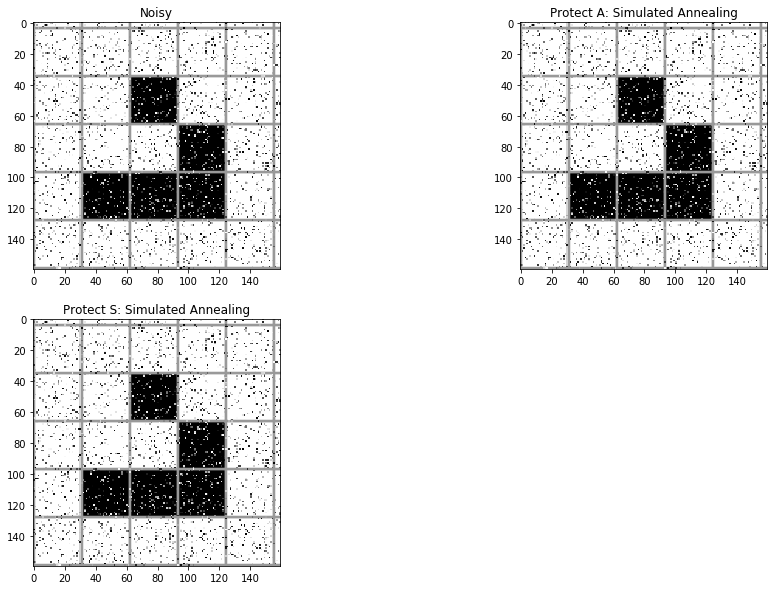

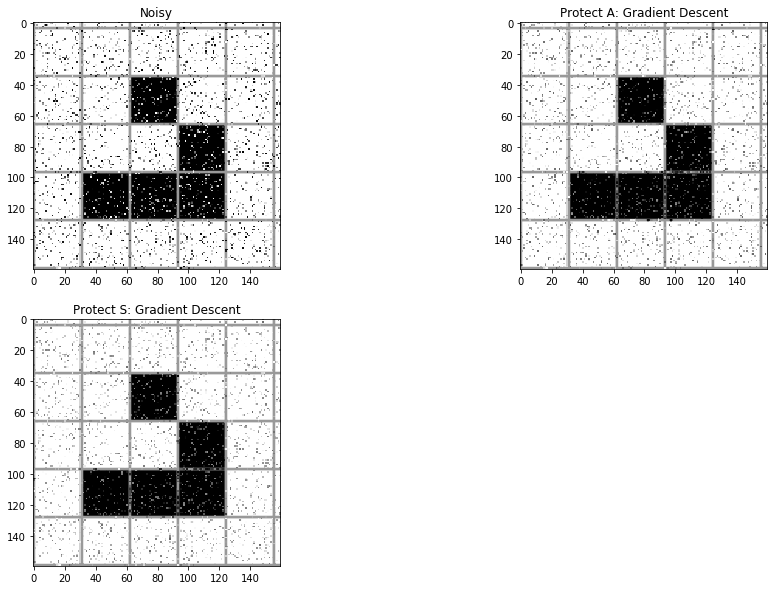

In [15]:
medFilterProtectA = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                     alpha=0.1, beta=1, gamma=.1, 
                                                                     phi=0, sigma=0, eta=0)

medFilterProtectS = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                     alpha=0, beta=1, gamma=0.1, 
                                                                     phi=0, sigma=0.1, eta=0)

# denoise image with new energy functions
imrecMedProtectA = denoise(imnsy, medFilterProtectA, simulated_annealing)
imrecMedProtectS = denoise(imnsy, medFilterProtectS, simulated_annealing)

# compare result from different median filters
showimgs(imnsy, "Noisy", imrecMedProtectA, "Protect A: Simulated Annealing", imrecMedProtectS, "Protect S: Simulated Annealing")

# and compare that with gradient descent
imrecMedProtectAGradDesc = denoise(imnsy, medFilterProtectA, gradient_descent)
imrecMedProtectSGradDesc = denoise(imnsy, medFilterProtectS, gradient_descent)
showimgs(imnsy, "Noisy", imrecMedProtectAGradDesc, "Protect A: Gradient Descent", imrecMedProtectSGradDesc, "Protect S: Gradient Descent")


From these results it is clear that gradient descent is a superior approach to denoising for this image and noise value.  In fact simulated annealing seems to yield no visible improvement, whereas gradient descent with both energy function parameter sets significantly improved the noisiness of the image.  We would expect this, as the proportion of noisy to not noisy pixels is fairly low and thus randomly changing pixels' values is highly unlikely to decrease the level of noise, making simulated annealing a poor choice of algorithm in this situation.  Notice also how for the gradient descent, there is some smudging between the grey gridlines and the black squares, a form of edge deterioration.  We would expect to see more deterioration here because this energy function performs more poorly in lower contrast areas.  Finally, notice that the protect S energy function better preserves the grey gridlines in the denoised image than protect A.  Further improvement could likely be made to the gradient descent denoiser by further tweaking the energy function parameters, but even in its current state it significantly reduces the amount of noise in the image.